### Load Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm # run OLS linear regression
from statsmodels.graphics.factorplots import interaction_plot # plot interaction

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
spending = pd.read_csv("../W8/lab07_customers.csv")
spending.head()

,spend,race,income,age,sex,schoolYears
0,715.243646,white,38511.0,34.0,male,0.0
1,883.720255,other,280882.0,38.0,male,0.0
2,755.915697,white,160952.0,48.0,female,0.0
3,652.697972,white,73221.0,32.0,male,0.0
4,575.359129,white,17415.0,29.0,male,0.0


### 1. Build a linear regression with all the dependant variables and the interactions from the lab

In [3]:
# create dummy variables
sp = pd.concat([spending, pd.get_dummies(spending[["race", "sex"]], prefix = ["race", "sex"])], axis = 1)

# create interaction terms
sp["hispanic_male"] = sp.apply(lambda x: 1 if (x["race"] == "hispanic") & (x["sex"] == "male") else 0, axis = 1)
sp["black_female"] = sp.apply(lambda x: 1 if (x["race"] == "black") & (x["sex"] == "female") else 0, axis = 1)
sp["asian_female"] = sp.apply(lambda x: 1 if (x["race"] == "asian") & (x["sex"] == "female") else 0, axis = 1)
sp["educated_female"] = sp.apply(lambda x: 1 if (x["sex"] == "female") & (x["schoolYears"] == 1) else 0, axis = 1)
sp["educated_asian"] = sp.apply(lambda x: 1 if (x["race"] == "asian") & (x["schoolYears"] == 1) else 0, axis = 1)
sp["educated_asian_female"] = sp.apply(lambda x: 1 if (x["race"] == "asian") & (x["sex"] == "female") & (x["schoolYears"] == 1) else 0, axis = 1)

# transform income (age is not able to transform, so leave it be - normal enough)
sp["LNincome"] = np.log(sp["income"])

In [4]:
X = sp[["LNincome", "age", "schoolYears", "race_asian", "race_black", "race_hispanic", "race_white",
        "sex_male", "sex_female", "hispanic_male", "black_female", "asian_female", "educated_female", "educated_asian",
        "educated_asian_female"]]
y = sp["spend"]

In [5]:
model_lr = sm.OLS(y, sm.add_constant(X)).fit()
model_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  spend   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     5787.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):               0.00
Time:                        21:48:00   Log-Likelihood:                -51739.
No. Observations:               10000   AIC:                         1.035e+05
Df Residuals:                    9988   BIC:                         1.036e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -247.0738     13.562    -18.219      0.000    -273.657    -220.490
LNincome                 16.7310      0.427     39.213      0.000      15.895      17.567
age                      20.7141      0.105    196.784      0.000      20.508      20.920
schoolYears              23.0173      0.703     32.744      0.000      21.639      24.395
race_asian                8.5266      2.783      3.064      0.002       3.072      13.982
race_black               -0.4463      2.230     -0.200      0.841      -4.818       3.926
race_hispanic             1.1951      2.108      0.567      0.571      -2.937       5.327
race_white                5.0611      1.392      3.636      0.000       2.332       7.790
sex_male                 94.9926     12.382      7.672      0.000      70.722     119.263
sex_female             -201.2418     12.563    -16.019      0.000    -225.867    -176.617
hispanic_male           151.1170      2.550     59.269      0.000     146.119     156.115
black_female           -209.6685      2.709    -77.397      0.000    -214.979    -204.358
asian_female             23.0173      0.703     32.744      0.000      21.639      24.395
educated_female          23.0173      0.703     32.744      0.000      21.639      24.395
educated_asian           23.0173      0.703     32.744      0.000      21.639      24.395
educated_asian_female    23.0173      0.703     32.744      0.000      21.639      24.395
==============================================================================
Omnibus:                      476.497   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              618.176
Skew:                           0.481   Prob(JB):                    5.82e-135
Kurtosis:                       3.746   Cond. No.                     6.40e+64
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.82e-123. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 2. Build ridge models with various values for alpha. Create a chart showing how the coefficients change with alpha values
reference: https://machinelearningmastery.com/ridge-regression-with-python/  
reference: https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html  
reference: https://www.pluralsight.com/guides/linear-lasso-ridge-regression-scikit-learn  
reference: http://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html

In [6]:
alphas = 10**np.linspace(5,-5,100)*0.5
coefs = []
mse = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    mse.append(mean_squared_error(y, ridge.predict(X)))

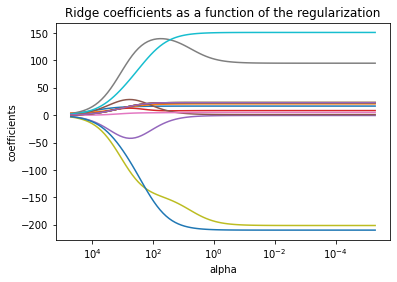

In [7]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

*As the plot above shows, the best alpha at which coefficients stablalize would be between 0.1 and 10, possibly more close to 0.1.*

In [8]:
# cross-validation for best Ridge alpha

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model_ridge_best = RidgeCV(alphas=np.arange(0, 1, 0.001), cv=cv, scoring="neg_mean_squared_error", fit_intercept=True)
# model_ridge_best = RidgeCV(cv=cv, scoring="neg_mean_squared_error")
model_ridge_best.fit(X, y)
print("With RidgeCV, the best alpha identified is:", model_ridge_best.alpha_)

With RidgeCV, the best alpha identified is: 0.382


### 3. Build lasso models with various values for alpha. Create a chart showing how the coefficients change with alpha values

In [9]:
lasso = Lasso(max_iter = 10000, normalize = True)
coef_lasso = []
mse_lasso = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coef_lasso.append(lasso.coef_)
    mse_lasso.append(mean_squared_error(y, lasso.predict(X)))

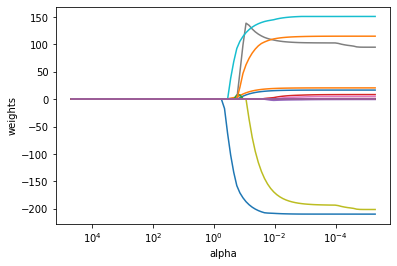

In [10]:
# plt.figure(figsize = (15,4))
ax = plt.gca()
ax.plot(alphas, coef_lasso)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

*As the graph shows, the alpha at which coefficients stablize is around 0.01.*

In [11]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model_lasso_best = LassoCV(alphas=None, cv=cv, max_iter = 100000, fit_intercept=True)
model_lasso_best.fit(X, y)

print("With LassoCV, the best alpha identified is", model_lasso_best.alpha_)

With LassoCV, the best alpha identified is 0.3411657805596771


### 4. Compare the coefficients from linear regression, ridge, and lasso (select an alpha value using your chart)

In [12]:
print("========== Linear coefficients ==========\n", model_lr.params)

========== Linear coefficients ==========
 const                   -247.073758
LNincome                  16.731040
age                       20.714053
schoolYears               23.017314
race_asian                 8.526570
race_black                -0.446285
race_hispanic              1.195117
race_white                 5.061055
sex_male                  94.992568
sex_female              -201.241795
hispanic_male            151.117036
black_female            -209.668530
asian_female              23.017314
educated_female           23.017314
educated_asian            23.017314
educated_asian_female     23.017314
dtype: float64


In [13]:
print("========== Ridge coefficients ==========")
for i in range(len(X.columns)):
    print(X.columns[i], "\t\t", model_ridge_best.coef_[i])

========== Ridge coefficients ==========
LNincome 		 16.729381766650445
age 		 20.705581787667825
schoolYears 		 23.017599566793546
race_asian 		 8.509503055462202
race_black 		 -0.6135932755013283
race_hispanic 		 1.294713296869411
race_white 		 5.054378004066066
sex_male 		 98.25567248620736
sex_female 		 -197.8883696817818
hispanic_male 		 150.8954933329863
black_female 		 -209.34941903068744
asian_female 		 23.017599566816084
educated_female 		 23.0175995668232
educated_asian 		 23.017599566823208
educated_asian_female 		 23.01759956681963


In [14]:
print("========== Lasso coefficients ==========")
for i in range(len(X.columns)):
    print(X.columns[i], "\t\t", model_lasso_best.coef_[i])

========== Lasso coefficients ==========
LNincome 		 16.354918995246933
age 		 20.368360889187663
schoolYears 		 0.0
race_asian 		 4.560510045181136
race_black 		 -4.414758788852227
race_hispanic 		 0.0
race_white 		 0.3869613994777981
sex_male 		 101.7359108507142
sex_female 		 -188.6944432140528
hispanic_male 		 143.1174771966463
black_female 		 -203.91639587949768
asian_female 		 104.6073082641507
educated_female 		 0.0
educated_asian 		 0.0
educated_asian_female 		 0.0


### 5. Compare the R2 from lr, ridge, and lasso

In [15]:
model_ridge_best_pred = model_ridge_best.predict(X)
model_lasso_best_pred = model_lasso_best.predict(X)
print("Linear R2:", model_lr.rsquared,
      "\nRidge R2:", r2_score(y, model_ridge_best_pred),
      "\nLasso R2:", r2_score(y, model_lasso_best_pred))

Linear R2: 0.8643841768850987 
Ridge R2: 0.8643829191127347 
Lasso R2: 0.8634729874055433


*The R2 from lr, ridge and lasso are very close to each other, with linear slightly larger.*

### 6. Which model would you choose, and why?

*I would choose the model with linear regression. It has the largest R2, even though three R2s are very similar. Regularization is not so necessary if R2s are pretty similar. Additionally, Ridge has a slightly smaller R2, and Lasso shrinks some predictors on which interactions are based, so Lasso might not be that good.*

### 7. Interpret your chosen model

- *The model R2 is 0.864, suggesting that around 86.4% of the variations in spending can be explained by the model.*   
- *In this model, almost all variables are significant. Variable race_black and race_hispanic are not significant, but they have to be kept in the model because their interactions are significant and will be kept.*
- *In this model, some strong variables are given larger coefficients. For example, black_female has a coefficient as large as -209.7, indicating it is a very strong predictor of spending in this dataset.*  